<div id="top" style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 37px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
  Vestiaire Collective Price Suggestion<br>
  </div> 

<div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 35px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
  -<br>
  </div> 
  
<div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 35px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
      2026_4S2MLP_23 - Machine learning in practice<br>Final Project<br>
  </div> 

<div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 25px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
      <font color=orange> Boudsalakham Saynorlath</font>
  </div>

<div style="font-variant: small-caps; 
      font-weight: normal; 
      font-size: 20px; 
      text-align: center; 
      padding: 15px; 
      margin: 10px;">
      BSc in Data Science for Responsible Business
  </div>

# Table Of Contents

- [Project Scope](#project-scope)
- [Data Preprocessing](#data-preprocessing)
- [Random Forest Model](#random-forest-model)
- [Boosted Trees](#boosted-trees)
- [Model Interpretation](#model-interpretation)

### Imports

In [1]:
# for package auto reload
%load_ext autoreload
%autoreload 2

# for better rendering of plots in jupyter notebook
%matplotlib inline

In [2]:
# base modules
from pathlib import Path
from collections import defaultdict
import math

# for manipulating data
import numpy as np
import pandas as pd
import scipy
import re
import dill

# for Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.inspection import permutation_importance

from catboost import CatBoostRegressor
from xgboost import XGBRegressor, plot_tree, plot_importance
import optuna

# for visualization
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
from eclyon.transforms import (
    add_date_columns, change_columns_from_str_to_categorical, process_df,fix_missing
)

In [4]:
from eclyon.transforms import process_df, split_vals
from eclyon.explain import rf_feat_importance

# Project Scope

We will focus on regression for price prediction. 98% of the observations are sold listings, so the model can act as a pricing guide to sell successfully, it would be of interest to the company itself since it is a feature already present on their platform, albeit in a version that suggests on the lower end. In terms of the dataset for pre-owned fashion, it is the one with the most features available on Kaggle, providing details on the level of product, brand, seller, market and user engagement.

[Back to Top](#table-of-contents)

### $\bullet$ The Dataset

The chosen dataset contains product listings from Vestiaire Collective, an online marketplace for buying and selling pre-owned luxury fashion items. It was scraped using Python and the Hrequests Library by Kaggle user JustinPakzad. The CSV file contains 900514 rows and 36 columns.

[Back to Top](#table-of-contents)

In [5]:
path_to_repo = Path('..').resolve()
path_to_data = path_to_repo / 'data'

In [6]:
df_raw = pd.read_csv(path_to_data / 'vestiaire.csv', low_memory = False)

In [7]:
df_raw = df_raw.convert_dtypes()

In [8]:
df_raw = df_raw.drop(df_raw[df_raw.sold].index)
df_raw = df_raw.drop(columns = ['sold'])

In [9]:
df_raw

,product_id,product_type,product_name,product_description,product_keywords,product_gender_target,product_category,product_season,product_condition,product_like_count,...,warehouse_name,seller_id,seller_username,usually_ships_within,seller_country,seller_products_sold,seller_num_products_listed,seller_community_rank,seller_num_followers,seller_pass_rate
1,43247441,Jacket,Jacket Barbara Bui Navy size 42 FR in Cotton,For selling nice women's suit Barbara Bui size...,Barbara Bui Cotton Jackets,Women,Women Clothing,All seasons,Very good condition,1,...,Tourcoing,13698770,olivia13698770,<NA>,Belgium,0,0,0,8,0.0
2,43246517,Wool coat,Wool coat Comme Des Garcons White size S Inter...,Magnificent boiled wool coat. I bought it in t...,Comme Des Garcons Wool Coats,Women,Women Clothing,Autumn / Winter,Very good condition,2,...,Tourcoing,6042365,cecilia6042365,1-2 days,Spain,58,69,0,62,96.0
3,43246507,Mini skirt,Mini skirt MSGM Black size 38 IT in Polyester,MSGM Skirt Black Printed Raw-Edge & Embroidere...,MSGM Polyester Skirts,Women,Women Clothing,All seasons,Very good condition,0,...,Brooklyn,13172949,gretchen13172949,1-2 days,United States,63,274,126346,131,96.0
4,43246417,Vegan leather trousers,Vegan leather trousers LVIR Black size 36 FR i...,LVIR black grained faux leather trousers size ...,LVIR Vegan leather Trousers,Women,Women Clothing,All seasons,Very good condition,1,...,Crawley,2578605,crunchykat,3-5 days,United Kingdom,19,14,102821,40,89.0
5,43246347,Mid-length dress,Mid,"See By Chloe white dress, size 42 IT (size lik...",See by Chloé Cotton - elasthane Dresses,Women,Women Clothing,All seasons,Very good condition,0,...,Tourcoing,3062607,julie3062607,1-2 days,France,3,22,493200,21,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900509,41538360,Glitter trainers,Glitter trainers Bally Gold size 38 EU in Glit...,"Bally Vita Parcours sneakers. PPleather, suede...",Bally Glitter Trainers,Women,Women Shoes,All seasons,Good condition,1,...,Tourcoing,8849230,lauragua,1-2 days,Italy,40,17,391778,104,100.0
900510,41532271,Leather heels,Leather heels Casadei Black size 38.5 EU in Le...,Trendy and classic Casadei high-heel pumps Mad...,Casadei Leather Heels,Women,Women Shoes,All seasons,Good condition,1,...,Tourcoing,5448248,bettina5448248,1-2 days,Austria,26,99,51408,75,89.0
900511,41538140,Leather cowboy boots,Leather cowboy boots Ash Black size 36 EU in L...,Very good quality leather boots Worn once Elas...,Ash Leather Boots,Women,Women Shoes,All seasons,Very good condition,0,...,Tourcoing,9347694,sylvie9347694,<NA>,France,0,2,0,3,0.0
900512,41537603,Leather ballet flats,Leather ballet flats Lauren Ralph Lauren Black...,Very beautiful ballet flats like new. I don't ...,Lauren Ralph Lauren Leather Ballet flats,Women,Women Shoes,All seasons,Very good condition,27,...,Tourcoing,24074881,marina24074881,1-2 days,Italy,2,7,0,11,100.0


In [10]:
df_raw.columns

Index(['product_id', 'product_type', 'product_name', 'product_description',
       'product_keywords', 'product_gender_target', 'product_category',
       'product_season', 'product_condition', 'product_like_count', 'reserved',
       'available', 'in_stock', 'should_be_gone', 'brand_id', 'brand_name',
       'brand_url', 'product_material', 'product_color', 'price_usd',
       'seller_price', 'seller_earning', 'seller_badge',
       'has_cross_border_fees', 'buyers_fees', 'warehouse_name', 'seller_id',
       'seller_username', 'usually_ships_within', 'seller_country',
       'seller_products_sold', 'seller_num_products_listed',
       'seller_community_rank', 'seller_num_followers', 'seller_pass_rate'],
      dtype='object')

In [11]:
len(df_raw.columns)

35

In [12]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [13]:
df_raw.shape

(886778, 35)

In [14]:
display_all(df_raw.head().T)

,1,2,3,4,5
product_id,43247441,43246517,43246507,43246417,43246347
product_type,Jacket,Wool coat,Mini skirt,Vegan leather trousers,Mid-length dress
product_name,Jacket Barbara Bui Navy size 42 FR in Cotton,Wool coat Comme Des Garcons White size S Inter...,Mini skirt MSGM Black size 38 IT in Polyester,Vegan leather trousers LVIR Black size 36 FR i...,Mid
product_description,For selling nice women's suit Barbara Bui size...,Magnificent boiled wool coat. I bought it in t...,MSGM Skirt Black Printed Raw-Edge & Embroidere...,LVIR black grained faux leather trousers size ...,"See By Chloe white dress, size 42 IT (size lik..."
product_keywords,Barbara Bui Cotton Jackets,Comme Des Garcons Wool Coats,MSGM Polyester Skirts,LVIR Vegan leather Trousers,See by Chloé Cotton - elasthane Dresses
product_gender_target,Women,Women,Women,Women,Women
product_category,Women Clothing,Women Clothing,Women Clothing,Women Clothing,Women Clothing
product_season,All seasons,Autumn / Winter,All seasons,All seasons,All seasons
product_condition,Very good condition,Very good condition,Very good condition,Very good condition,Very good condition
product_like_count,1,2,0,1,0


In [15]:
display_all(df_raw.describe(include = 'all').T)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
product_id,886778.0,<NA>,<NA>,<NA>,38043685.8869,7783475.698654,111363.0,38009494.5,41712462.0,42667573.75,43248835.0
product_type,886778,10847,Sunglasses,42558,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_name,886778,522407,T,24357,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_description,886771,823165,Very good condition,2141,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_keywords,885604,123911,Gucci Plastic Sunglasses,4046,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_gender_target,886778,2,Women,473924,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_category,885604,6,Men Clothing,190347,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_season,886776,3,All seasons,736618,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_condition,886778,5,Very good condition,394874,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_like_count,886778.0,<NA>,<NA>,<NA>,6.163922,12.749625,0.0,1.0,3.0,7.0,3154.0


### $\bullet$ Variable to predict

[Back to Top](#top)

The variable we want to predict is the sale price of a listing, based on its description i.e. the other columns as **explanatory variables**.

Our metric is RMSLE between the actual and predicted listing prices, this allows us to predict a listed price's order of magnitude which is relevant since we are dealing with luxury fashion of every category e.g. bags, shoes, etc. Therefore we take the log of the prices, so that RMSE will give us what we need.

In [16]:
df_raw = df_raw.drop(columns = ['seller_price', 'seller_earning','buyers_fees'])

df_raw.price_usd

1          127.8
2         1278.0
3          163.9
4         119.72
5         108.63
           ...  
900509     89.46
900510    153.36
900511     191.7
900512     57.51
900513     958.5
Name: price_usd, Length: 886778, dtype: Float64

In [17]:
df_raw.price_usd = np.log(df_raw.price_usd)

df_raw.price_usd

1         4.850467
2         7.153052
3         5.099256
4         4.785156
5         4.687948
            ...   
900509    4.493792
900510    5.032788
900511    5.255932
900512    4.051959
900513     6.86537
Name: price_usd, Length: 886778, dtype: Float64

### $\bullet$  Naive RF

[Back to Top](#top)

We shall try an arbitrary random forest regression to set the baseline for performance.

In [18]:
def rmse(y_gold, y_pred): 
    return math.sqrt(((y_gold - y_pred)**2).mean())

def print_score(m, X_train, y_train, X_valid, y_valid):
    print('RMSE on train set: {:.4f}'.format(rmse(m.predict(X_train), y_train)))
    print('RMSE on valid set: {:.4f}'.format(rmse(m.predict(X_valid), y_valid)))
    print('R^2 on train set: {:.4f}'.format(m.score(X_train, y_train)))
    print('R^2 on valid set: {:.4f}'.format(m.score(X_valid, y_valid)))
    if hasattr(m, 'oob_score_'): print('R^2 on oob set: {:.4f}'.format(m.oob_score_))
    return

In [19]:
df, y, nas = process_df(df_raw, y_field = 'price_usd')

n_total = len(df)
n_valid = 12000  
n_train = n_total - n_valid
n_small = 50000

X_train, X_valid = split_vals(df, n_train)
y_train, y_valid = split_vals(y, n_train)
X_small, _ = split_vals(df, n_small)
y_small, _ = split_vals(y, n_small)

base_model = RandomForestRegressor(n_estimators = 10, n_jobs = -1, random_state = 42)
%time base_model.fit(X_small, y_small)
print_score(base_model, X_small, y_small, X_valid, y_valid) 

CPU times: user 7.04 s, sys: 42 ms, total: 7.09 s
Wall time: 1.37 s
RMSE on train set: 0.3006
RMSE on valid set: 0.8545
R^2 on train set: 0.9126
R^2 on valid set: 0.2091


# Data Preprocessing

[Back to top](#top)

We introduce a new feature which is the mean brand popularity, scraped from Google Trends. We do so using a dictionary applied to a numpy array for speed: _np.vectorize_ allows us to apply the dictionary's _.get_ attribute to each element of the array.

In [ ]:
df_brand_popularity_mean = pd.read_csv(path_to_data /'brand_popularity_mean.csv')

df_brand_popularity_mean

,Unnamed: 0,brand,value
0,0,& Other Stories,62.811321
1,1,(+) PEOPLE,83.283019
2,2,032c,0.000000
3,3,10 Crosby by Derek Lam,0.000000
4,4,1017 ALYX 9SM,0.000000
...,...,...,...
2190,2190,octopus,28.000000
2191,2191,takeo kikuchi,4.018868
2192,2192,valstar,0.000000
2193,2193,yamamay,0.000000


In [21]:
brand_popularity_dict = dict(zip(df_brand_popularity_mean.brand,df_brand_popularity_mean.value))

brands = df_raw['brand_name'].to_numpy()

brand_popularity_col = np.vectorize(brand_popularity_dict.get)(brands)

df_raw['brand_popularity_mean'] = brand_popularity_col

We process the shipping time interval into two numerical columns using the same technique.

In [22]:
df_raw.usually_ships_within.unique()

<StringArray>
[<NA>, '1-2 days', '3-5 days', '6-7 days', 'More than 7 days']
Length: 5, dtype: string

In [23]:
shipping_lower_bound = {
    '1-2 days':1,
    '3-5 days':3,
    '6-7 days':6,
    'More than 7 days':7
}

shipping_upper_bound = {
    '1-2 days':2,
    '3-5 days':5,
    '6-7 days':7,
    'More than 7 days':None
}

In [24]:
shipping_time = df_raw.usually_ships_within.to_numpy()

shipping_fastest_col = np.vectorize(shipping_lower_bound.get)(shipping_time)
shipping_latest_col = np.vectorize(shipping_upper_bound.get)(shipping_time)

df_raw['shipping_fastest'] = shipping_fastest_col
df_raw['shipping_latest'] = shipping_latest_col

We know that a product's type e.g. shoes, accessories, bags are great features to discriminate pricing. Clearly, if given the same brand, a hairclip and a full-length coat will not be priced the same. Unfortunately, the _product_type_ column mixes the product's type with the product's material i.e. "Wool Coat" instead of just "Coat".

We apply our _add_normalized_product_type_ function to introduce a simplified product typology which relies on regex.

In [25]:
category_patterns = [
    #shoes
    ("clogs",    r"(?i)\b(mules? & clogs?|clogs?)\b"), 
    ("heels",          r"(?i)\b(escarpins|heel|heels|pumps?|pointe|studs?)\b"),
    ("flats",          r"(?i)\b(flat|flats|ballet flats?|ballerina|espadrilles?)\b"),
    ("mules",          r"(?i)\b(mule|mules)\b"),
    ("lace_ups",       r"(?i)\b(lace[- ]?up|lace[- ]?ups|oxfords?)\b"),
    ("flip_flops",     r"(?i)\b(flip[- ]?flop|flip[- ]?flops|slides?)\b"),
    ("sneakers",       r"(?i)\b(sneaker|sneakers|trainer|trainers|running shoes?|baskets?)\b"),
    ("boots",          r"(?i)\b(boot|boots|bott?e?s?)\b"),
    ("loafers",        r"(?i)\b(loafer|loafers|moccasin|mocassins)\b"),
    ("sandals",        r"(?i)\b(sandal|sandals|sandale|sandales)\b"),
    ("other_shoes",    r"(?i)\b(shoe|shoes|chaussure|chaussures)\b"),

    #accessories
    ("watch",          r"(?i)\b(watch|watches|montre|montres)\b"),
    ("glasses",     r"(?i)\b(sunglasses|glasses|lunette|lunettes|goggle)\b"),
    ("jewelry",        r"(?i)\b(jewelry|jewellery|cufflink|cufflinks|jewel|jewels|bracelet|bracelets|necklace|necklaces|ring|rings|earring|earrings|bijou|bijoux|choker)\b"),
    ("belt",           r"(?i)\b(belt|belts|ceinture|ceintures)\b"),
    ("tie",            r"(?i)\b(tie|ties|cravate|cravates)\b"),
    ("hat",            r"(?i)\b(hat|hats|cap|caps|beanie|panama|beanies|bonnet|bonnets|beret)\b"),
    ("gloves",         r"(?i)\b(glove|gloves|gant|gants|mittens)\b"),
    ("wallet",         r"(?i)\b(wallet|wallets|porte[- ]?feuilles?)\b"),
    ("bag",            r"(?i)\b(bag|bags|sac\b|sacs\b|purse|purses|clutch|clutches|wallet|wallets|porte[- ]?feuilles?|pouch|pouches|trousse|trousses)\b"),
    ("backpack",       r"(?i)\b(backpack|backpacks|sac à dos)\b"),
    ("haberdashery",   r"(?i)\b(cloth|poncho|cape|scarf|scarves|écharpe|foulard|foulards|handkerchiefs?|neckerchiefs?|carr[ée]?\s*90|gavroche|twilly|stole|stoles|cheche|chèches|shawl|shawls|châle|châles?)\b"),
    ("other_accessory",r"(?i)\b(case|diary|leather|accessory|accessories|accessoire|accessoires|accs?)\b"),

    #formalwear
    ("suit",           r"(?i)\b(suit|suits|costume|costumes)\b"),
    ("tailored_jacket",r"(?i)\b(tailor(?:ed)? jacket|veste de costume)\b"),

    #outerwear
    ("leather_jacket", r"(?i)\b(leather jackets?|veste en cuir|cuir\b)\b"),
    ("puffer",         r"(?i)\b(doudounes?|puffer|puffers)\b"),
    ("parka",          r"(?i)\b(parkas?)\b"),
    ("trench",         r"(?i)\b(trenchcoat|trench|trenches)\b"),
    ("coat",           r"(?i)\b(caban|Peacoat|dufflecoat|coat|coats|manteau|manteaux|overcoat|overcoats)\b"),
    ("blazer",         r"(?i)\b(blazer|blazers)\b"),
    ("jacket",         r"(?i)\b(jacket|jackets|veste|vestes)\b"),

    #tops
    ("hoodie",         r"(?i)\b(hoodie|hoodies|hooded)\b"),
    ("sweatshirt",     r"(?i)\b(sweatshirt|sweatshirts|sweat)\b"),
    ("shirt",          r"(?i)\b(shirt|shirts|chemise|chemises|polo|polos|t[- ]?shirts?|tee shirts?)\b"),
    ("vest",           r"(?i)\b(vest|vests|gilet|gilets)\b"),
    ("knitwear",       r"(?i)\b(knitwear|cardigan|cardigans|gilet maille|knit|knits|pull|pulls|jumper|jumpers|maille|tricots?)\b"),
    ("other_tops",r"(?i)\b(combishort|twin-set|corset|tunic|jumpsuit|blouse|top)\b"),

    #bottoms
    ("jeans",          r"(?i)\b(jean|jeans|denim)\b"),
    ("trousers",       r"(?i)\b(pants?|trouser|trousers|pantalon|pantalons)\b"),
    ("shorts",         r"(?i)\b(short|shorts|bermuda|bermudas)\b"),
    ("dress",          r"(?i)\b(slip|dress|dresses|robe|robes)\b"),
    ("skirt",          r"(?i)\b(skirt|skirts|jupe|jupes)\b"),
    ("other_bottoms",r"(?i)\b(overall|harem|leggings|bottom)\b"),

    #swim & underwear
    ("swimwear",       r"(?i)\b(pareo|swimwear|swim|swimsuit|maillots?)\b"),
    ("underwear",      r"(?i)\b(tight|bustier|string|camisole|bra|lingerie|underwear|boxers?|sous[- ]?vêtements?)\b"),
]

def normalize_product_type(text):
    if pd.isna(text):
        return None
    txt = text.lower()

    for category, pattern in category_patterns:
        if re.search(pattern, txt):
            return category

    return None

def add_normalized_product_type(df, source_col="product_type"):
    df = df.copy()

    df["product_type_normalized"] = (
        df[source_col]
        .astype(str)
        .apply(normalize_product_type)
    )

    return df

In [26]:
df_raw = add_normalized_product_type(df_raw)

While product color influences price, we cannot know the exact ranking of color by influence on price. What we do know is that neutral colors hold their value better in the second hand market. So we code an is_neutral feature with True for neutral colors and False otherwise.

In [27]:
df_raw.product_color.unique().tolist()

['Navy',
 'White',
 'Black',
 'Beige',
 'Red',
 'Green',
 'Blue',
 'Khaki',
 'Multicolour',
 'Grey',
 'Metallic',
 'Turquoise',
 'Yellow',
 'Brown',
 'Pink',
 'Ecru',
 'Orange',
 'Burgundy',
 'Purple',
 'Gold',
 'Anthracite',
 'Camel',
 'Silver',
 'Charcoal',
 'Bordeaux',
 'White / Black',
 'camel',
 'Beige / Grey',
 'silver/black',
 <NA>,
 'brown/black']

In [28]:
neutral_color_dict = {
    'Anthracite': True,
    'Beige': True,
    'Beige / Grey': True,
    'Black': True,
    'Brown': True,
    'Camel': True,
    'Charcoal': True,
    'Ecru': True,
    'Grey': True,
    'Khaki': True,
    'Metallic': True,
    'Navy': True,
    'Silver': True,
    'White': True,
    'White / Black': True,
    'brown/black': True,
    'camel': True,
    'silver/black': True,

    'Blue': False,
    'Bordeaux': False,
    'Burgundy': False,
    'Gold': False,
    'Green': False,
    'Multicolour': False,
    'Orange': False,
    'Pink': False,
    'Purple': False,
    'Red': False,
    'Turquoise': False,
    'Yellow': False
}

In [29]:
colors = df_raw.product_color.to_numpy()

neutral_col = np.vectorize(neutral_color_dict.get)(colors)

df_raw['color_is_neutral'] = neutral_col

Like the _product_type_ column, we must also process the _product_material_ column as it has too many values. We will narrow them down to more basic categories which bare clear pricing differences that we can more easily order later on.

In [30]:
material_type_dict = {
    # Synthetic fabrics
    "Plastic": "synthetic fabrics",
    "Synthetic": "synthetic fabrics",
    "Polyester": "synthetic fabrics",
    "Polyamide": "synthetic fabrics",
    "Spandex": "synthetic fabrics",
    "Lycra": "synthetic fabrics",
    "Vinyl": "synthetic fabrics",
    "Glitter": "synthetic fabrics",
    "Rubber": "synthetic fabrics",
    "Vegan leather": "synthetic fabrics",
    "Faux fur": "synthetic fabrics",

    # Natural fibers and materials
    "Cotton": "natural fibers",
    "Cotton - elasthane": "natural fibers",
    "Denim - Jeans": "natural fibers",
    "Linen": "natural fibers",
    "Wool": "natural fibers",
    "Silk": "natural fibers",
    "Velvet": "natural fibers",
    "Tweed": "natural fibers",
    "Cloth": "natural fibers",
    "Lace": "natural fibers",
    "Cashmere": "natural fibers",
    "Wicker": "natural fibers",
    "Wood": "natural fibers",

    # Jewelry materials 
    "Glass": "jewelry material",
    "Chain": "jewelry material",
    "Crystal": "jewelry material",
    "Pearl": "jewelry material",
    "Pearls": "jewelry material",
    "Silver Plated": "jewelry material",
    "Silver Gilt": "jewelry material",
    "Gold plated": "jewelry material",
    "Metal": "jewelry material",
    "gold and steel": "jewelry material",

    # Precious metals 
    "Silver": "precious metals",
    "Gold": "precious metals",
    "Yellow gold": "precious metals",
    "White gold": "precious metals",
    "Pink gold": "precious metals",
    "Platinum": "precious metals",
    "Titanium": "precious metals",

    # Real leathers
    "Pony-style calfskin": "leathers",
    "Patent leather": "leathers",
    "Leather": "leathers",
    "Suede": "leathers",
    "Shearling": "leathers",

    # Furs
    "Mongolian Lamb": "furs",
    "Rabbit": "furs",
    "Beaver": "furs",
    "Fox": "furs",
    "Raccoon": "furs",

    # Exotic leathers
    "Chinchilla": "exotic leathers",
    "Mink": "exotic leathers",
    "Ostrich": "exotic leathers",
    "Alligator": "exotic leathers",
    "Crocodile": "exotic leathers",
    "Python": "exotic leathers",
    "Lizard": "exotic leathers",
    "Water snake": "exotic leathers",
    "Exotic leathers": "exotic leathers",
    "Varan": "exotic leathers",
    "Eel": "exotic leathers",

    # Other
    "Ceramic": "other",
    "Not specified": "other",
}

In [31]:
materials = df_raw.product_material.to_numpy()

material_type_col = np.vectorize(material_type_dict.get)(materials)

df_raw['material_type'] = material_type_col

We introduce a _brand_median_ column where for a given product, the value is the median price of the product's brand minus the product itself. Including the given product in the median calculation introduces leakage so we avoid that.

In [32]:
brand_counts = df_raw.groupby(['brand_id'], as_index=False).product_id.count()

brand_counts = brand_counts[brand_counts.product_id > 200]

df_filtered = pd.merge(df_raw, brand_counts, on=['brand_id'], how='inner')

df_filtered = df_filtered.rename(columns = {'product_id_x':'product_id'})

In [33]:
def leave_one_out_median(col):
    val = col.to_numpy()
    n = len(val)

    order = np.argsort(val)
    sorted_vals = val[order]

    res_col = np.empty(n)

    for i in range(n):
        if i == 0:
            remain_vals = sorted_vals[1:]
        elif i == n - 1:
            remain_vals = sorted_vals[:-1]
        else:
            remain_vals = np.concatenate((sorted_vals[:i], sorted_vals[i+1:]))

        res_col[order[i]] = np.median(remain_vals)

    return res_col


In [34]:
for brand in df_filtered.brand_id.values.unique():
    df_brand = df_raw[df_raw.brand_id == brand]
    df_raw.loc[df_brand.index,'brand_median'] = leave_one_out_median(df_brand.price_usd)

Now we move on to encoding the categorical features will small numbers of categories and clear ordinality.

In [35]:
df_transformed = change_columns_from_str_to_categorical(df_raw)

In [36]:
df_transformed.seller_badge.cat.categories.tolist()

['Common', 'Expert', 'Trusted']

In [37]:
df_transformed.seller_badge = df_transformed.seller_badge.cat.set_categories(['Common','Trusted','Expert'], ordered = True)

In [38]:
df_transformed.product_condition.cat.categories.tolist()

['Fair condition',
 'Good condition',
 'Never worn',
 'Never worn, with tag',
 'Very good condition']

In [39]:
df_transformed.product_condition = df_transformed.product_condition.cat.set_categories(
['Fair condition','Good condition','Very good condition','Never worn','Never worn, with tag'], ordered = True)

In [40]:
df_transformed.material_type.cat.categories.tolist()

['None',
 'exotic leathers',
 'furs',
 'jewelry material',
 'leathers',
 'natural fibers',
 'other',
 'precious metals',
 'synthetic fabrics']

In [41]:
df_transformed.material_type = df_transformed.material_type.cat.set_categories(
['None',
 'other',
 'synthetic fabrics',
 'jewelry material',
 'natural fibers',
 'leathers',
 'furs',
 'exotic leathers',
 'precious metals']
, ordered = True)

In [42]:
df_transformed.usually_ships_within.cat.categories.tolist()

['1-2 days', '3-5 days', '6-7 days', 'More than 7 days']

In [43]:
df_transformed.usually_ships_within = df_transformed.usually_ships_within.cat.set_categories(
    ['More than 7 days','6-7 days','3-5 days','1-2 days'],ordered=True
)

We check for missing values. No empty columns or alarming percentages, _process_df_ will take care of the missing values.

In [44]:
display_all(df_raw.isnull().sum().sort_values(ascending=False)/len(df_raw))

shipping_latest               0.174443
usually_ships_within          0.173087
shipping_fastest              0.173087
brand_median                  0.169930
brand_popularity_mean         0.046517
product_keywords              0.001324
product_category              0.001324
seller_username               0.000044
product_description           0.000008
product_material              0.000005
product_season                0.000002
product_type_normalized       0.000001
product_color                 0.000001
seller_products_sold          0.000000
material_type                 0.000000
seller_country                0.000000
color_is_neutral              0.000000
seller_num_products_listed    0.000000
seller_community_rank         0.000000
seller_pass_rate              0.000000
seller_id                     0.000000
seller_num_followers          0.000000
product_id                    0.000000
warehouse_name                0.000000
has_cross_border_fees         0.000000
seller_badge             

# Random Forest Model

[Back to Top](#top)

In [45]:
df, y, nas = process_df(df_transformed, y_field = 'price_usd')

In [46]:
df

,product_id,product_type,product_name,product_description,product_keywords,product_gender_target,product_category,product_season,product_condition,product_like_count,...,seller_pass_rate,brand_popularity_mean,shipping_fastest,shipping_latest,product_type_normalized,color_is_neutral,material_type,brand_median,brand_popularity_mean_na,brand_median_na
1,43247441,4762,115282,274738,13417,2,5,1,3,1,...,0.0,61.226415,0,0,15,True,5,4.799173,False,False
2,43246517,10617,481093,425313,27465,2,5,2,3,2,...,96.0,74.867925,1,1,6,True,5,5.320470,False,False
3,43246507,6356,292502,421787,72025,2,5,1,3,0,...,96.0,70.660377,1,1,29,True,3,4.687948,False,False
4,43246417,10243,452579,384982,64168,2,5,1,3,1,...,89.0,60.679245,2,2,21,True,3,5.320470,True,True
5,43246347,6330,281488,598612,104287,2,5,1,3,0,...,100.0,49.773585,1,1,7,True,5,4.733915,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900509,41538360,4343,97547,76830,12750,2,6,1,2,1,...,100.0,12.716981,1,1,30,False,3,5.068086,False,False
900510,41532271,5429,194761,683158,22670,2,6,1,2,1,...,89.0,25.018868,1,1,14,True,6,5.432673,False,False
900511,41538140,5417,179652,714128,9875,2,6,1,3,0,...,0.0,29.150943,0,0,4,True,6,4.493792,False,False
900512,41537603,5392,154842,707591,65624,2,6,1,3,27,...,100.0,49.433962,1,1,8,True,6,4.404155,False,False


We anticipate that _brand_median_ will be an important feature and we introduce interaction terms. 

In [47]:
df['brand_median x brand_id'] = df.brand_median.to_numpy() * df.brand_id.to_numpy()

df['brand_median x brand_popularity_mean'] = df.brand_median.to_numpy() * df.brand_popularity_mean.to_numpy()

df['brand_median x product_condition'] = df.brand_median.to_numpy() * df.product_condition.to_numpy()

df['brand_median x product_like_count'] = df.brand_median.to_numpy() * df.product_like_count.to_numpy()

df['brand_median x seller_num_followers'] = df.brand_median.to_numpy() * df.seller_num_followers.to_numpy()

df['brand_median x seller_country'] = df.brand_median.to_numpy() * df.seller_country.to_numpy()

df['product_type_normalized x material_type'] = df.product_type_normalized.to_numpy() * df.material_type.to_numpy()

df['product_type_normalized x brand_id'] = df.product_type_normalized.to_numpy() * df.brand_id.to_numpy()

df['seller_num_products_listed x seller_products_sold'] = df.seller_num_products_listed.to_numpy() * df.seller_products_sold.to_numpy()

df['material_type x brand_id'] = df.material_type.to_numpy() * df.brand_id.to_numpy()

In [48]:
n_total = len(df)
n_valid = 12000  # same as Kaggle's test set size
n_train = n_total - n_valid
n_small = 50000

X_train, X_valid = split_vals(df, n_train)
y_train, y_valid = split_vals(y, n_train)
X_small, _ = split_vals(df, n_small)
y_small, _ = split_vals(y, n_small)

### $\bullet$  Initial Model Training

[Back to Top](#top)

In [49]:
model = RandomForestRegressor(
    n_estimators = 78,
    min_samples_split = 180,
    min_samples_leaf= 55,
    max_features = 0.65, 
    n_jobs = -1, 
    random_state = 67,
    
    bootstrap = True,
    oob_score = True, 
    max_samples = 0.7, 
)

%time model.fit(X_small, y_small)
print_score(model, X_small, y_small, X_valid, y_valid) 

CPU times: user 23.6 s, sys: 90.1 ms, total: 23.7 s
Wall time: 3.61 s
RMSE on train set: 0.6270
RMSE on valid set: 0.6952
R^2 on train set: 0.6195
R^2 on valid set: 0.4766
R^2 on oob set: 0.5959


We are badly overfitting as the training and validation score have a difference over 0.05 and the OOB score is way lower than training.

### $\bullet$  Model Optimization With Optuna

[Back to Top](#top)

In [50]:
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 0.65,
 'max_leaf_nodes': None,
 'max_samples': 0.7,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 55,
 'min_samples_split': 180,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 78,
 'n_jobs': -1,
 'oob_score': True,
 'random_state': 67,
 'verbose': 0,
 'warm_start': False}

In [51]:
def objective(trial, X_training, y_training, X_validation, y_validation):
    """
    This function estimates a trial quality.
    It contains the 4 steps : hp sampling, model definition, training and evaluation.
    
    Parameters:
    ----------
    trial (optuna.trial.Trial): the trial at stake
    X_training: pd.DataFrame. Table containing features used for training.
    X_validation: pd.DataFrame. Table containing features used for validation.
    y_training: array-like. List of true target variable values for training.
    y_validation: array-like. List of true target variable values for validation.

    Returns:
    -------
    float: performance metric value (R^2)
    """
    
    n_estimators_guess = trial.suggest_int("n_estimators", 60, 150) 
    max_features_guess = trial.suggest_float("max_features", 0.4, 0.8) 
    max_samples_guess = trial.suggest_float("max_samples", 0.6, 0.8) 
    min_samples_leaf_guess = trial.suggest_int("min_samples_leaf", 30, 80)  
    min_samples_split_guess = trial.suggest_int("min_samples_split", 100, 250) 
    max_depth_guess = trial.suggest_int("max_depth", 5, 25) 

    
    optuna_RF = RandomForestRegressor(
    n_estimators = n_estimators_guess,
    min_samples_split = min_samples_split_guess,
    min_samples_leaf= min_samples_leaf_guess,
    max_features = max_features_guess, 
    n_jobs = -1, 
    random_state = 67,
    max_depth=max_depth_guess,
    
    bootstrap = True,
    oob_score = True, 
    max_samples = max_samples_guess, 
)
    
    optuna_RF.fit(X_training, y_training)
    
    y_pred_validation = optuna_RF.predict(X_validation)
    r2_validation = metrics.r2_score(y_validation, y_pred_validation)
    return r2_validation

In [52]:
study = optuna.create_study(study_name="rf_opt", 
                            load_if_exists=True, 
                            storage = "sqlite:///opt.db",
                            direction="maximize")

study.optimize(lambda trial: objective(trial, X_small, y_small, X_valid, y_valid), n_trials=1, show_progress_bar=True)

[I 2025-12-07 21:32:20,712] Using an existing study with name 'rf_opt' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2025-12-07 21:32:23,999] Trial 55 finished with value: 0.470670062909056 and parameters: {'n_estimators': 102, 'max_features': 0.6507734402940032, 'max_samples': 0.763055528554019, 'min_samples_leaf': 64, 'min_samples_split': 212, 'max_depth': 6}. Best is trial 55 with value: 0.470670062909056.


In [53]:
study.best_params

{'n_estimators': 102,
 'max_features': 0.6507734402940032,
 'max_samples': 0.763055528554019,
 'min_samples_leaf': 64,
 'min_samples_split': 212,
 'max_depth': 6}

In [54]:
best_rf = {'n_estimators': 86,
 'max_features': 0.46010136749304,
 'max_samples': 0.7819244091920281,
 'min_samples_leaf': 66,
 'min_samples_split': 148,
 'max_depth': 18}

In [55]:
model = RandomForestRegressor(
    n_estimators = best_rf['n_estimators'],
    min_samples_split = best_rf['min_samples_split'],
    min_samples_leaf= best_rf['min_samples_leaf'],
    max_features = best_rf['max_features'], 
    max_depth=best_rf['max_depth'],
    n_jobs = -1, 
    random_state = 67,
    
    bootstrap = True,
    oob_score = True, 
    max_samples = best_rf['max_samples'], 
)

%time model.fit(X_train, y_train)
print_score(model, X_train, y_train, X_valid, y_valid) 

CPU times: user 12min 6s, sys: 4.82 s, total: 12min 11s
Wall time: 1min 56s
RMSE on train set: 0.5581
RMSE on valid set: 0.5421
R^2 on train set: 0.7129
R^2 on valid set: 0.6817
R^2 on oob set: 0.6976


We improved performance and are not overfitting. The training and validation difference is controlled as it now sits at about 0.03.

In [56]:
with open(path_to_repo / 'saves' / 'RandF_regressor.pk', 'wb') as file:
    dill.dump(model, file) 

# Boosted Trees

[Back to Top](#top)

Our ML problem seems too complex for random forest regression. We improve performance by testing boosted tree models. We will use optuna to search for optimal hyperparameters.

### $\bullet$ Performance Function

[Back to Top](#top)

In [57]:
def reg_perf(regressor, X_training, X_validation, y_true_training, y_true_validation, plot=True):
    """
    Evaluate the performance of a regression model.

    Parameters
    ----------
    regressor: sklearn.base.BaseEstimator. A trained scikit-learn regressor.
    X_training: pd.DataFrame. Table containing features used for training.
    X_validation: pd.DataFrame. Table containing features used for validation.
    y_true_training: array-like. List of true target variable values for training.
    y_true_validation: array-like. List of true target variable values for validation.
    plot: boolean. Whether to show a scatter plot of truth versus predictions.
    """
    y_pred_training = regressor.predict(X_training)
    y_pred_validation = regressor.predict(X_validation)
    rmse_training = metrics.root_mean_squared_error(y_true_training, y_pred_training)
    rmse_validation = metrics.root_mean_squared_error(y_true_validation, y_pred_validation)
    r2_training = metrics.r2_score(y_true_training, y_pred_training)
    r2_validation = metrics.r2_score(y_true_validation, y_pred_validation)
    print("RMSE on training set : {:.3f}".format(rmse_training))
    print("RMSE on validation set : {:.3f}".format(rmse_validation))
    print("R^2 on training set : {:.3f}".format(r2_training))
    print("R^2 on validation set : {:.3f}".format(r2_validation))

    if plot:
        sns.regplot(x=y_true_validation, y=y_pred_validation,  scatter_kws={'s': 1, 'alpha':0.7})
        plt.xlabel("true target variable")
        plt.ylabel("predicted target variable")
        plt.title("Regressor prediction vs truth on validation set")
        plt.show()

### $\bullet$ Initial XGBoost Model

[Back to Top](#top)

[0]	validation_0-rmse:0.96749
[1]	validation_0-rmse:0.91814
[2]	validation_0-rmse:0.87217
[3]	validation_0-rmse:0.83421
[4]	validation_0-rmse:0.80053
[5]	validation_0-rmse:0.78144
[6]	validation_0-rmse:0.76079
[7]	validation_0-rmse:0.74791
[8]	validation_0-rmse:0.73961
[9]	validation_0-rmse:0.73419
[10]	validation_0-rmse:0.73231
[11]	validation_0-rmse:0.72560
[12]	validation_0-rmse:0.72354
[13]	validation_0-rmse:0.71994
[14]	validation_0-rmse:0.71996
[15]	validation_0-rmse:0.72015
[16]	validation_0-rmse:0.72062
[17]	validation_0-rmse:0.72055
[18]	validation_0-rmse:0.71877
[19]	validation_0-rmse:0.71963
[20]	validation_0-rmse:0.72221
[21]	validation_0-rmse:0.72172
[22]	validation_0-rmse:0.72374
[23]	validation_0-rmse:0.72260
[24]	validation_0-rmse:0.72798
[25]	validation_0-rmse:0.72904
[26]	validation_0-rmse:0.73093
[27]	validation_0-rmse:0.74120
[28]	validation_0-rmse:0.74291
[29]	validation_0-rmse:0.75143
[30]	validation_0-rmse:0.75164
[31]	validation_0-rmse:0.75211
[32]	validation_0-

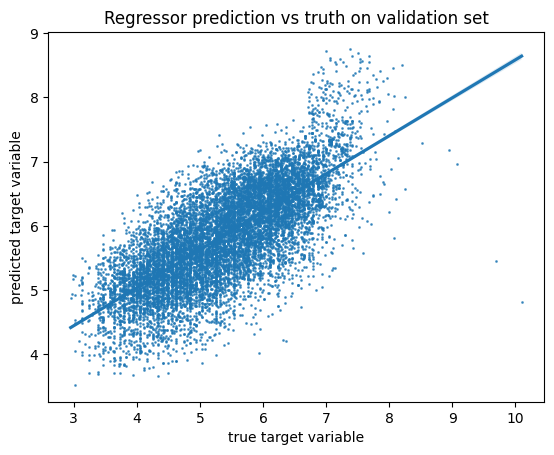

In [58]:
xgb = XGBRegressor(
    n_estimators=100,        
    learning_rate=0.1,       
    max_depth=6,             
    min_child_weight=1,      
    gamma=0.0,               
    subsample=1.0,           
    colsample_bytree=1.0,   
    colsample_bylevel=1.0,   
    colsample_bynode=1.0,    
    reg_alpha=0.0,           
    reg_lambda=1.0,          
    tree_method="hist",      
    booster="gbtree",        
    objective="reg:squarederror",
    eval_metric=None,        
    early_stopping_rounds=None,  
    random_state=42,
    verbosity=1              
)
%time xgb.fit(X_small, y_small, eval_set=[(X_valid, y_valid)])
reg_perf(xgb, X_small, X_valid, y_small, y_valid, plot=True)

We can already anticipate good performance so we shall proceed directly to optimization with Optuna.

### $\bullet$ Model Optimization With Optuna

[Back to Top](#top)

In [59]:
def objective(trial, X_training, y_training, X_validation, y_validation):
    """
    This function estimates a trial quality.
    It contains the 4 steps : hp sampling, model definition, training and evaluation.
    
    Parameters:
    ----------
    trial (optuna.trial.Trial): the trial at stake
    X_training: pd.DataFrame. Table containing features used for training.
    X_validation: pd.DataFrame. Table containing features used for validation.
    y_training: array-like. List of true target variable values for training.
    y_validation: array-like. List of true target variable values for validation.

    Returns:
    -------
    float: performance metric value (R^2)
    """
    
    learning_rate_guess = trial.suggest_float("learning_rate", 0.01, 0.02)
    max_depth_guess = trial.suggest_int("max_depth", 7, 10)
    reg_lambda_guess = trial.suggest_int("reg_lambda", 22, 26)
    min_child_weight_guess = trial.suggest_int("min_child_weight", 15, 22)  
    subsample_guess = trial.suggest_float("subsample", 0.5, 0.6)           
    gamma_guess = trial.suggest_float("gamma", 3.5, 4)                    
    n_estimators_guess = trial.suggest_int("n_estimators", 1000, 1200) 
    reg_alpha_guess = trial.suggest_float("reg_alpha", 0.0, 1.5)     
    tree_method_guess = trial.suggest_categorical("tree_method", ["hist", "approx"])
    grow_policy_guess = trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    early_stopping_rounds_guess=trial.suggest_int("early_stopping_rounds", 45, 55)
    
    xgb = XGBRegressor(
        n_estimators=n_estimators_guess,
        max_depth=max_depth_guess,  
        early_stopping_rounds= early_stopping_rounds_guess,                             
        random_state=42,
        learning_rate=learning_rate_guess,       
        verbosity=0,     
        reg_lambda=reg_lambda_guess,
        gamma=gamma_guess,
        min_child_weight=min_child_weight_guess,
        subsample=subsample_guess,
        reg_alpha = reg_alpha_guess, 
        tree_method=tree_method_guess,
        grow_policy=grow_policy_guess,
    )
    
    xgb.fit(
    X_training,
    y_training,
    eval_set=[(X_validation, y_validation)], 
)
    
    y_pred_validation = xgb.predict(X_validation)
    r2_validation = metrics.r2_score(y_validation, y_pred_validation)
    return r2_validation

In [60]:
study = optuna.create_study(study_name="xgb_opt", 
                            load_if_exists=True, 
                            storage = "sqlite:///opt.db",
                            direction="maximize")

study.optimize(lambda trial: objective(trial, X_small, y_small, X_valid, y_valid), n_trials=1, show_progress_bar=True)

[I 2025-12-07 21:34:25,978] Using an existing study with name 'xgb_opt' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

[0]	validation_0-rmse:1.01804
[1]	validation_0-rmse:1.00788
[2]	validation_0-rmse:0.99795
[3]	validation_0-rmse:0.98813
[4]	validation_0-rmse:0.97865
[5]	validation_0-rmse:0.96850
[6]	validation_0-rmse:0.95949
[7]	validation_0-rmse:0.94965
[8]	validation_0-rmse:0.94108
[9]	validation_0-rmse:0.93229
[10]	validation_0-rmse:0.92424
[11]	validation_0-rmse:0.91657
[12]	validation_0-rmse:0.90891
[13]	validation_0-rmse:0.90094
[14]	validation_0-rmse:0.89326
[15]	validation_0-rmse:0.88553
[16]	validation_0-rmse:0.87859
[17]	validation_0-rmse:0.87191
[18]	validation_0-rmse:0.86489
[19]	validation_0-rmse:0.85882
[20]	validation_0-rmse:0.85187
[21]	validation_0-rmse:0.84602
[22]	validation_0-rmse:0.84008
[23]	validation_0-rmse:0.83438
[24]	validation_0-rmse:0.82884
[25]	validation_0-rmse:0.82305
[26]	validation_0-rmse:0.81776
[27]	validation_0-rmse:0.81274
[28]	validation_0-rmse:0.80727
[29]	validation_0-rmse:0.80291
[30]	validation_0-rmse:0.79850
[31]	validation_0-rmse:0.79389
[32]	validation_0-

In [61]:
study.best_params

{'learning_rate': 0.017488233006398735,
 'max_depth': 8,
 'reg_lambda': 24,
 'min_child_weight': 21,
 'subsample': 0.5533023887452739,
 'gamma': 3.586763208300847,
 'n_estimators': 1164,
 'reg_alpha': 0.15822443767828373,
 'tree_method': 'hist',
 'grow_policy': 'depthwise',
 'early_stopping_rounds': 47}

In [62]:
best_xgb = {'learning_rate': 0.01662748745335026,
 'max_depth': 8,
 'reg_lambda': 25,
 'min_child_weight': 18,
 'subsample': 0.5102017085440329,
 'gamma': 3.7829376493930718,
 'n_estimators': 1058,
 'reg_alpha': 0.4720452089671082,
 'tree_method': 'hist',
 'grow_policy': 'depthwise'}

Note: The XGBoost model was further handtweaked for better performance.

[0]	validation_0-rmse:0.88646
[1]	validation_0-rmse:0.81880
[2]	validation_0-rmse:0.77127
[3]	validation_0-rmse:0.73757
[4]	validation_0-rmse:0.71294
[5]	validation_0-rmse:0.69397
[6]	validation_0-rmse:0.67664
[7]	validation_0-rmse:0.66454
[8]	validation_0-rmse:0.65741
[9]	validation_0-rmse:0.64722
[10]	validation_0-rmse:0.63717
[11]	validation_0-rmse:0.63063
[12]	validation_0-rmse:0.62518
[13]	validation_0-rmse:0.62186
[14]	validation_0-rmse:0.61665
[15]	validation_0-rmse:0.61472
[16]	validation_0-rmse:0.61206
[17]	validation_0-rmse:0.61214
[18]	validation_0-rmse:0.60789
[19]	validation_0-rmse:0.60542
[20]	validation_0-rmse:0.60386
[21]	validation_0-rmse:0.60220
[22]	validation_0-rmse:0.60192
[23]	validation_0-rmse:0.60072
[24]	validation_0-rmse:0.59854
[25]	validation_0-rmse:0.59657
[26]	validation_0-rmse:0.59553
[27]	validation_0-rmse:0.59372
[28]	validation_0-rmse:0.59365
[29]	validation_0-rmse:0.59255
[30]	validation_0-rmse:0.59173
[31]	validation_0-rmse:0.59073
[32]	validation_0-

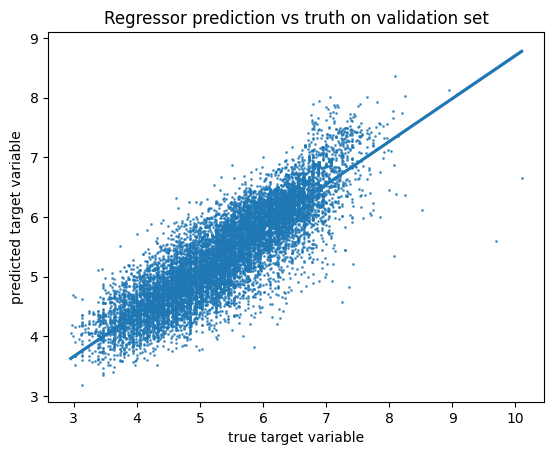

In [63]:
xgb_best = XGBRegressor(
    n_estimators=2000,        
    learning_rate=0.2,       
    max_depth=4,   
    min_child_weight = 18,          
    early_stopping_rounds=50,           
    random_state=42,
    reg_lambda=25,
    verbosity=1,
    reg_alpha= 0.4720452089671082        
)
%time xgb_best.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])
reg_perf(xgb_best, X_train, X_valid, y_train, y_valid, plot=True)

XGBoost gives the best model so far and we are barely overfitting. Given that we actually have numerous categorical features, we will also try CatBoost.

In [64]:
with open(path_to_repo / 'saves' / 'XGB_regressor.pk', 'wb') as file:
    dill.dump(xgb_best, file) 

### $\bullet$ Initial CatBoost Model

[Back to Top](#top)

We prepare our categorical features by converting its type, impute missing values with a new category: "missing".

In [65]:
X_cat = df_transformed.drop("price_usd", axis=1)
cat_features = X_cat.select_dtypes(include=['object', 'category']).columns.tolist()
for col in cat_features:
    X_cat[col] = X_cat[col].astype("category")
    X_cat[col] = X_cat[col].cat.add_categories("missing")
    X_cat[col] = X_cat[col].fillna("missing")
print(cat_features)
X_cat.head()

['product_type', 'product_name', 'product_description', 'product_keywords', 'product_gender_target', 'product_category', 'product_season', 'product_condition', 'brand_name', 'brand_url', 'product_material', 'product_color', 'seller_badge', 'warehouse_name', 'seller_username', 'usually_ships_within', 'seller_country', 'shipping_fastest', 'shipping_latest', 'product_type_normalized', 'material_type']


,product_id,product_type,product_name,product_description,product_keywords,product_gender_target,product_category,product_season,product_condition,product_like_count,...,seller_community_rank,seller_num_followers,seller_pass_rate,brand_popularity_mean,shipping_fastest,shipping_latest,product_type_normalized,color_is_neutral,material_type,brand_median
1,43247441,Jacket,Jacket Barbara Bui Navy size 42 FR in Cotton,For selling nice women's suit Barbara Bui size...,Barbara Bui Cotton Jackets,Women,Women Clothing,All seasons,Very good condition,1,...,0,8,0.0,61.226415,missing,missing,jacket,True,natural fibers,4.799173
2,43246517,Wool coat,Wool coat Comme Des Garcons White size S Inter...,Magnificent boiled wool coat. I bought it in t...,Comme Des Garcons Wool Coats,Women,Women Clothing,Autumn / Winter,Very good condition,2,...,0,62,96.0,74.867925,1,2,coat,True,natural fibers,5.320470
3,43246507,Mini skirt,Mini skirt MSGM Black size 38 IT in Polyester,MSGM Skirt Black Printed Raw-Edge & Embroidere...,MSGM Polyester Skirts,Women,Women Clothing,All seasons,Very good condition,0,...,126346,131,96.0,70.660377,1,2,skirt,True,synthetic fabrics,4.687948
4,43246417,Vegan leather trousers,Vegan leather trousers LVIR Black size 36 FR i...,LVIR black grained faux leather trousers size ...,LVIR Vegan leather Trousers,Women,Women Clothing,All seasons,Very good condition,1,...,102821,40,89.0,NaN,3,5,other_accessory,True,synthetic fabrics,NaN
5,43246347,Mid-length dress,Mid,"See By Chloe white dress, size 42 IT (size lik...",See by Chloé Cotton - elasthane Dresses,Women,Women Clothing,All seasons,Very good condition,0,...,493200,21,100.0,49.773585,1,2,dress,True,natural fibers,4.733915


CPU times: user 6.7 s, sys: 1.24 s, total: 7.95 s
Wall time: 1.93 s
RMSE on training set : 0.545
RMSE on validation set : 0.931
R^2 on training set : 0.713
R^2 on validation set : 0.062


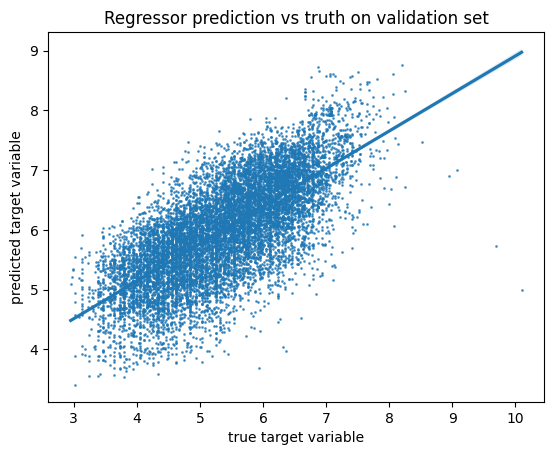

In [66]:
catboost = CatBoostRegressor(
    n_estimators = 500, 
    random_seed = 42,
    loss_function = 'RMSE',
    custom_metric = 'R2',
    logging_level = 'Silent',
    learning_rate = 0.1,
    depth = 5,
    l2_leaf_reg = 3.0,
    early_stopping_rounds = 50
)
%time catboost.fit(X_small, np.array(y_small))
reg_perf(catboost, X_small, X_valid, y_small, y_valid, plot=True)

### $\bullet$ Model Optimization With Optuna

[Back to Top](#top)

In [67]:
def objective(trial, X_training, y_training, X_validation, y_validation):
    """
    This function estimates a trial quality.
    It contains the 4 steps : hp sampling, model definition, training and evaluation.
    
    Parameters:
    ----------
    trial (optuna.trial.Trial): the trial at stake
    X_training: pd.DataFrame. Table containing features used for training.
    X_validation: pd.DataFrame. Table containing features used for validation.
    y_training: array-like. List of true target variable values for training.
    y_validation: array-like. List of true target variable values for validation.

    Returns:
    -------
    float: performance metric value (R^2)
    """
    
    n_estimators_guess = trial.suggest_int("n_estimators", 300, 550)
    learning_rate_guess = trial.suggest_float("learning_rate", 0.1, 0.3)
    depth_guess = trial.suggest_int("depth", 3, 8)
    l2_leaf_reg_guess = trial.suggest_float("l2_leaf_reg", 5, 20)
    min_data_in_leaf_guess = trial.suggest_int("min_data_in_leaf", 70, 250)
    subsample_guess = trial.suggest_float("subsample", 0.6, 0.9)
    random_strength_guess = trial.suggest_float("random_strength", 3, 5)
    early_stopping_rounds_guess = trial.suggest_int("early_stopping_rounds", 40, 60)
    
    catboost = CatBoostRegressor(
        n_estimators = n_estimators_guess, 
        learning_rate=learning_rate_guess,
        depth=depth_guess,
        l2_leaf_reg=l2_leaf_reg_guess,
        min_data_in_leaf=min_data_in_leaf_guess,
        subsample=subsample_guess,
        random_strength=random_strength_guess,
        loss_function='RMSE',
        custom_metric='R2',
        early_stopping_rounds=early_stopping_rounds_guess,
        random_seed=42,
        logging_level='Silent',
        cat_features=cat_features,
)
    
    catboost.fit(
    X_training,
    np.array(y_training,dtype=np.float64),
    eval_set=[(X_validation, np.array(y_validation,dtype=np.float64))], 
)
    
    y_pred_validation = catboost.predict(X_validation)
    r2_validation = metrics.r2_score(y_validation, y_pred_validation)
    return r2_validation

In [68]:
study = optuna.create_study(study_name="cat_opt", 
                            load_if_exists=True, 
                            storage = "sqlite:///opt.db",
                            direction="maximize")

study.optimize(lambda trial: objective(trial, X_small, y_small, X_valid, y_valid), n_trials=1, show_progress_bar=True)

[I 2025-12-07 21:35:10,093] Using an existing study with name 'cat_opt' instead of creating a new one.


  0%|          | 0/1 [00:00<?, ?it/s]

[I 2025-12-07 21:35:13,869] Trial 2 finished with value: 0.4763319717670842 and parameters: {'n_estimators': 368, 'learning_rate': 0.11938089548902778, 'depth': 8, 'l2_leaf_reg': 5.827535980232889, 'min_data_in_leaf': 152, 'subsample': 0.7004641975467664, 'random_strength': 3.4566241736336685, 'early_stopping_rounds': 42}. Best is trial 1 with value: 0.545445015194348.


In [69]:
study.best_params

{'n_estimators': 428,
 'learning_rate': 0.19734333828570955,
 'depth': 6,
 'l2_leaf_reg': 14.189674778353286,
 'min_data_in_leaf': 166,
 'subsample': 0.8840094955717537,
 'random_strength': 4.948437543419143,
 'early_stopping_rounds': 48}

In [70]:
best_cat = {'n_estimators': 716,
 'learning_rate': 0.16611407061796793,
 'depth': 5,
 'l2_leaf_reg': 1.426642692352091,
 'min_data_in_leaf': 193,
 'subsample': 0.5811715790323408,
 'random_strength': 3.4195559832085913,
 'early_stopping_rounds': 46}

CPU times: user 42min 42s, sys: 5min 33s, total: 48min 16s
Wall time: 9min 43s
RMSE on training set : 0.398
RMSE on validation set : 0.471
R^2 on training set : 0.854
R^2 on validation set : 0.760


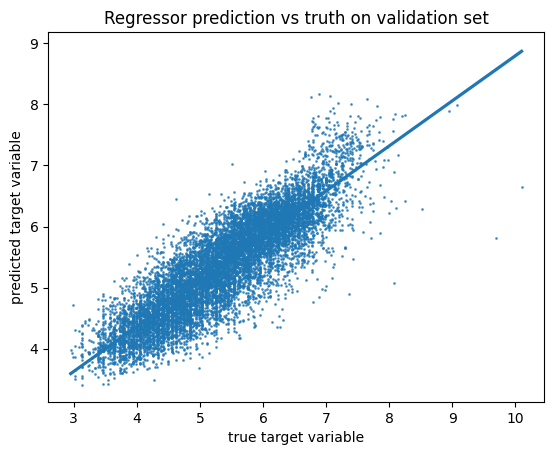

In [71]:
best_catboost = CatBoostRegressor(
    n_estimators = best_cat['n_estimators'],
    learning_rate = best_cat['learning_rate'],
    depth = best_cat['depth'],
    l2_leaf_reg = best_cat['l2_leaf_reg'],
    min_data_in_leaf = best_cat['min_data_in_leaf'],
    subsample = best_cat['subsample'],
    random_strength = best_cat['random_strength'],
    early_stopping_rounds = best_cat['early_stopping_rounds'],
    loss_function = "RMSE",
    custom_metric = "R2",
    random_seed = 42,
    logging_level = "Silent",
    cat_features = cat_features
)
%time best_catboost.fit(X_train, np.array(y_train))
reg_perf(best_catboost, X_train, X_valid, y_train, y_valid, plot=True)

In [72]:
with open(path_to_repo / 'saves' / 'CAT_regressor.pk', 'wb') as file:
    dill.dump(best_catboost, file) 

Our Catboost model gives us better performance but overfits. The difference in performance is a little more than one percent in validation score, so we proceed with Random Forest and especially XGBoost model for model interpretation as it gives good performance while generalizing well. 

# Model Interpretation

[Back to Top](#top)

### $\bullet$ Feature Importance Of The Whole Random Forest

[Back to Top](#top)

In [73]:
feat_importance = rf_feat_importance(model, X_train)
feat_importance[:20]

,cols,imp
37,brand_median,0.412051
42,brand_median x product_condition,0.118397
34,product_type_normalized,0.085093
41,brand_median x brand_popularity_mean,0.065731
46,product_type_normalized x material_type,0.031487
40,brand_median x brand_id,0.023612
6,product_category,0.022776
36,material_type,0.019919
2,product_name,0.018939
27,seller_num_products_listed,0.017266


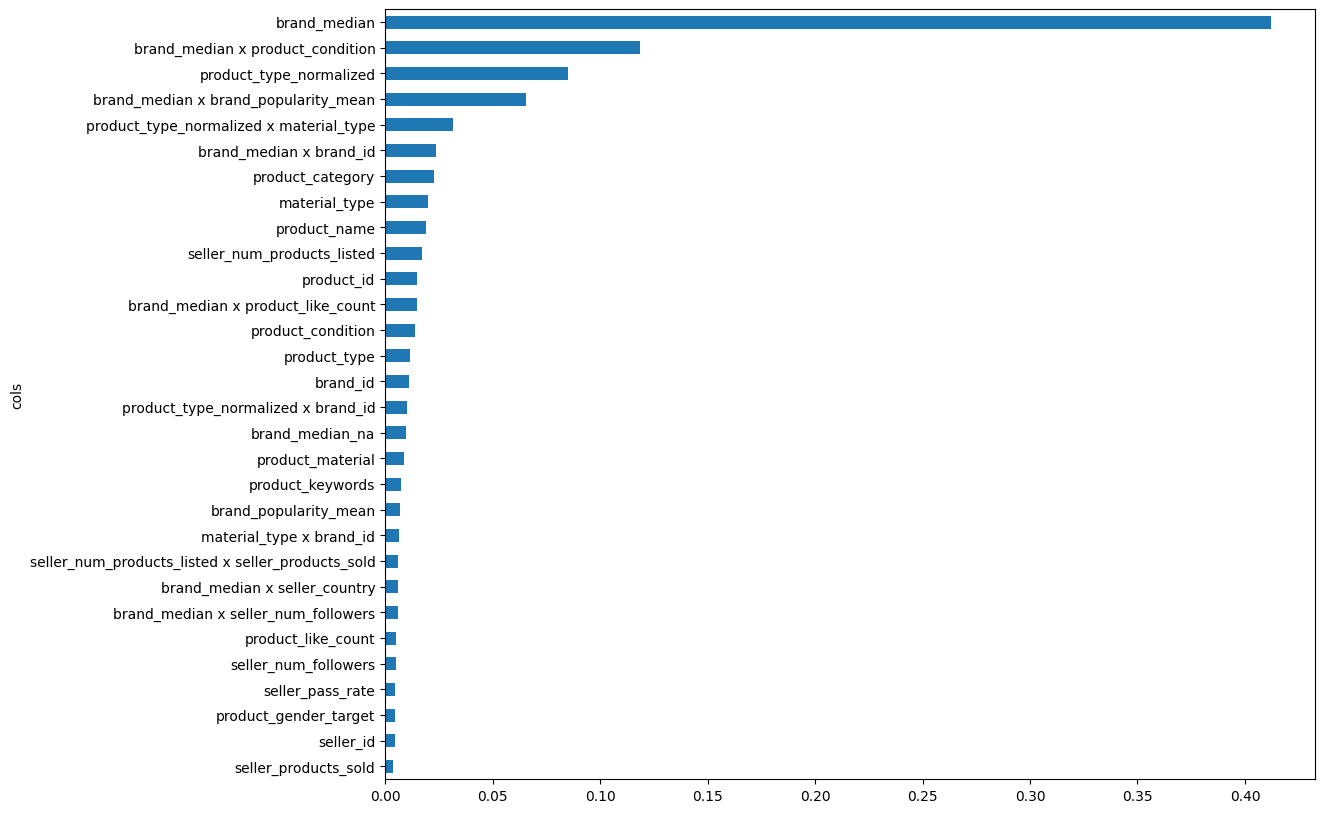

In [74]:
barh = feat_importance[:30].plot('cols', 'imp', 'barh', figsize = (12,10), legend = False)
barh = barh.invert_yaxis()
barh

The results highlight the success of our feature engineering on product and material typology. 

As expected, _brand_median_ is a good discriminant for pricing as it is a good proxy for a brand's price range.

_brand_median_ and _product_condition_ are a succesful interaction term, it shows that some brands can lose more value than others as product condition deteriorates.

_brand_median_ and _brand_popularity_mean_ shows that a brand may retain value if it is also popular.

#### Ablation Of Least Important Features

Least important features can be discarded before re-training the random forest, where it yields a slight improvement of the model's validation $R^2$ score :

In [75]:
to_keep = feat_importance[feat_importance.imp > 0.005].cols
len(to_keep)

25

In [76]:
to_keep

37                                         brand_median
42                     brand_median x product_condition
34                              product_type_normalized
41                 brand_median x brand_popularity_mean
46              product_type_normalized x material_type
40                              brand_median x brand_id
6                                      product_category
36                                        material_type
2                                          product_name
27                           seller_num_products_listed
0                                            product_id
43                    brand_median x product_like_count
8                                     product_condition
1                                          product_type
14                                             brand_id
47                   product_type_normalized x brand_id
39                                      brand_median_na
17                                     product_m

In [77]:
# perform ablation of columns with low importance
df_keep = df[to_keep].copy()

n_total = len(df_keep)
n_valid = 12000  # same as Kaggle's test set size
n_train = n_total - n_valid
n_small = 50000

X_train_keep, X_valid_keep = split_vals(df_keep, n_train)
y_train_keep, y_valid_keep = split_vals(y, n_train)

X_small_keep, _ = split_vals(df_keep, n_small)
y_small_keep, _ = split_vals(y, n_small)

print('Number of small training data points: X = {}, y = {}'.format(X_small_keep.shape, y_small_keep.shape))
print('Number of full training data points: X = {}, y = {}'.format(X_train_keep.shape, y_train_keep.shape))
print('Number of validation data points: X = {}, y = {}'.format(X_valid_keep.shape, y_valid_keep.shape))

Number of small training data points: X = (50000, 25), y = (50000,)
Number of full training data points: X = (874778, 25), y = (874778,)
Number of validation data points: X = (12000, 25), y = (12000,)


In [78]:
model_with_ablation = RandomForestRegressor(
    n_estimators = best_rf['n_estimators'],
    min_samples_split = best_rf['min_samples_split'],
    min_samples_leaf= best_rf['min_samples_leaf'],
    max_features = best_rf['max_features'], 
    max_depth=best_rf['max_depth'],
    n_jobs = -1, 
    random_state = 67,
    
    bootstrap = True,
    oob_score = True, 
    max_samples = best_rf['max_samples'], 
)

%time model_with_ablation.fit(X_small_keep, y_small_keep)

CPU times: user 12 s, sys: 57 ms, total: 12.1 s
Wall time: 1.88 s


RandomForestRegressor(max_depth=18, max_features=0.46010136749304,
                      max_samples=0.7819244091920281, min_samples_leaf=66,
                      min_samples_split=148, n_estimators=86, n_jobs=-1,
                      oob_score=True, random_state=67)

In [79]:
print('RF with ablation:')

print_score(model_with_ablation, X_small_keep, y_small_keep, X_valid_keep, y_valid_keep)

print('Original RF without ablation:')

print_score(model, X_small, y_small, X_valid, y_valid)

RF with ablation:
RMSE on train set: 0.6291
RMSE on valid set: 0.6866
R^2 on train set: 0.6170
R^2 on valid set: 0.4894
R^2 on oob set: 0.5937
Original RF without ablation:
RMSE on train set: 0.6034
RMSE on valid set: 0.5421
R^2 on train set: 0.6476
R^2 on valid set: 0.6817
R^2 on oob set: 0.6976


No significant improvement with ablation.

### $\bullet$ Feature Importance Of XGBoost

[Back to Top](#top)

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

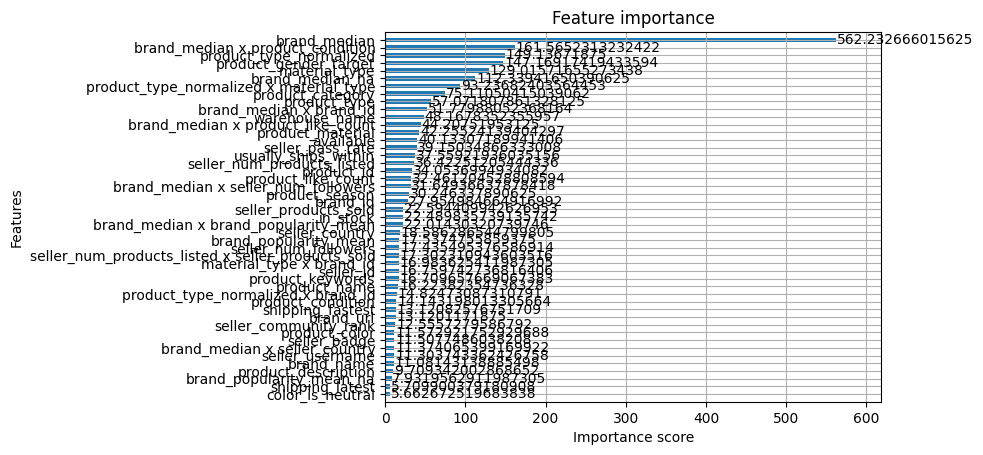

In [102]:
plot_importance(xgb_best, importance_type='gain', height=0.6 )

Gain here refers to how much a feature improves model accuracy i.e. reducing prediction error when it is used in a split.

Top three important features are the same as in RF. XGBoost seems to put more importance on _product_gender_target_ so there may be distinct pricing by gender target.

Material_type is also high in importance and naturally as some materials are more expensive than others and can be in a whole other proce range like for exotic leathers and precious metals. Note that its interaction term with normalized product_type is also important, so we may say that the effect of the material on resale price depends on the type of product, and the effect of the product type depends on the material.